In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(style='whitegrid', font_scale=0.9, rc={"lines.linewidth": 1.4,
                                           'lines.markersize': 1.6}, font="serif")

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='notebook', fscale=1, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size

from mpl_toolkits import mplot3d

/Users/dylancromer/.venvs/maszcal/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


In [4]:
import numpy as np
import maszcal.lensing.shear as shear
from maszcal.interp_utils import cartesian_prod
import supercubos
import pality

In [5]:
zs = np.linspace(0, 1, 16)
mus = np.linspace(np.log(1e13), np.log(1e15), 32)
model = shear.BaryonShearModel(
    mu_bins=mus, 
    redshift_bins=zs,
    delta=500,
    mass_definition='crit',
)

In [6]:
rs = np.logspace(np.log10(0.03), np.log10(30), 100)

param_mins = np.array([1, 0.1, 2, -2]) #con, alpha, beta, a_sz
param_maxes = np.array([4, 2, 5, 2])

num = 120

lh = supercubos.LatinSampler().get_lh_sample(
    param_mins=param_mins,
    param_maxes=param_maxes,
    num_samples=40,
)

cons = lh.T[0]
alphas = lh.T[1]
betas = lh.T[2]
gammas = np.ones(1) * 0.2
a_szs = lh.T[3]

esds = model.stacked_delta_sigma(rs, cons, alphas, betas, gammas, a_szs)

In [7]:
colors = ['#72a555', '#ab62c0', '#c57c3c', '#638ccc', '#ca5670']

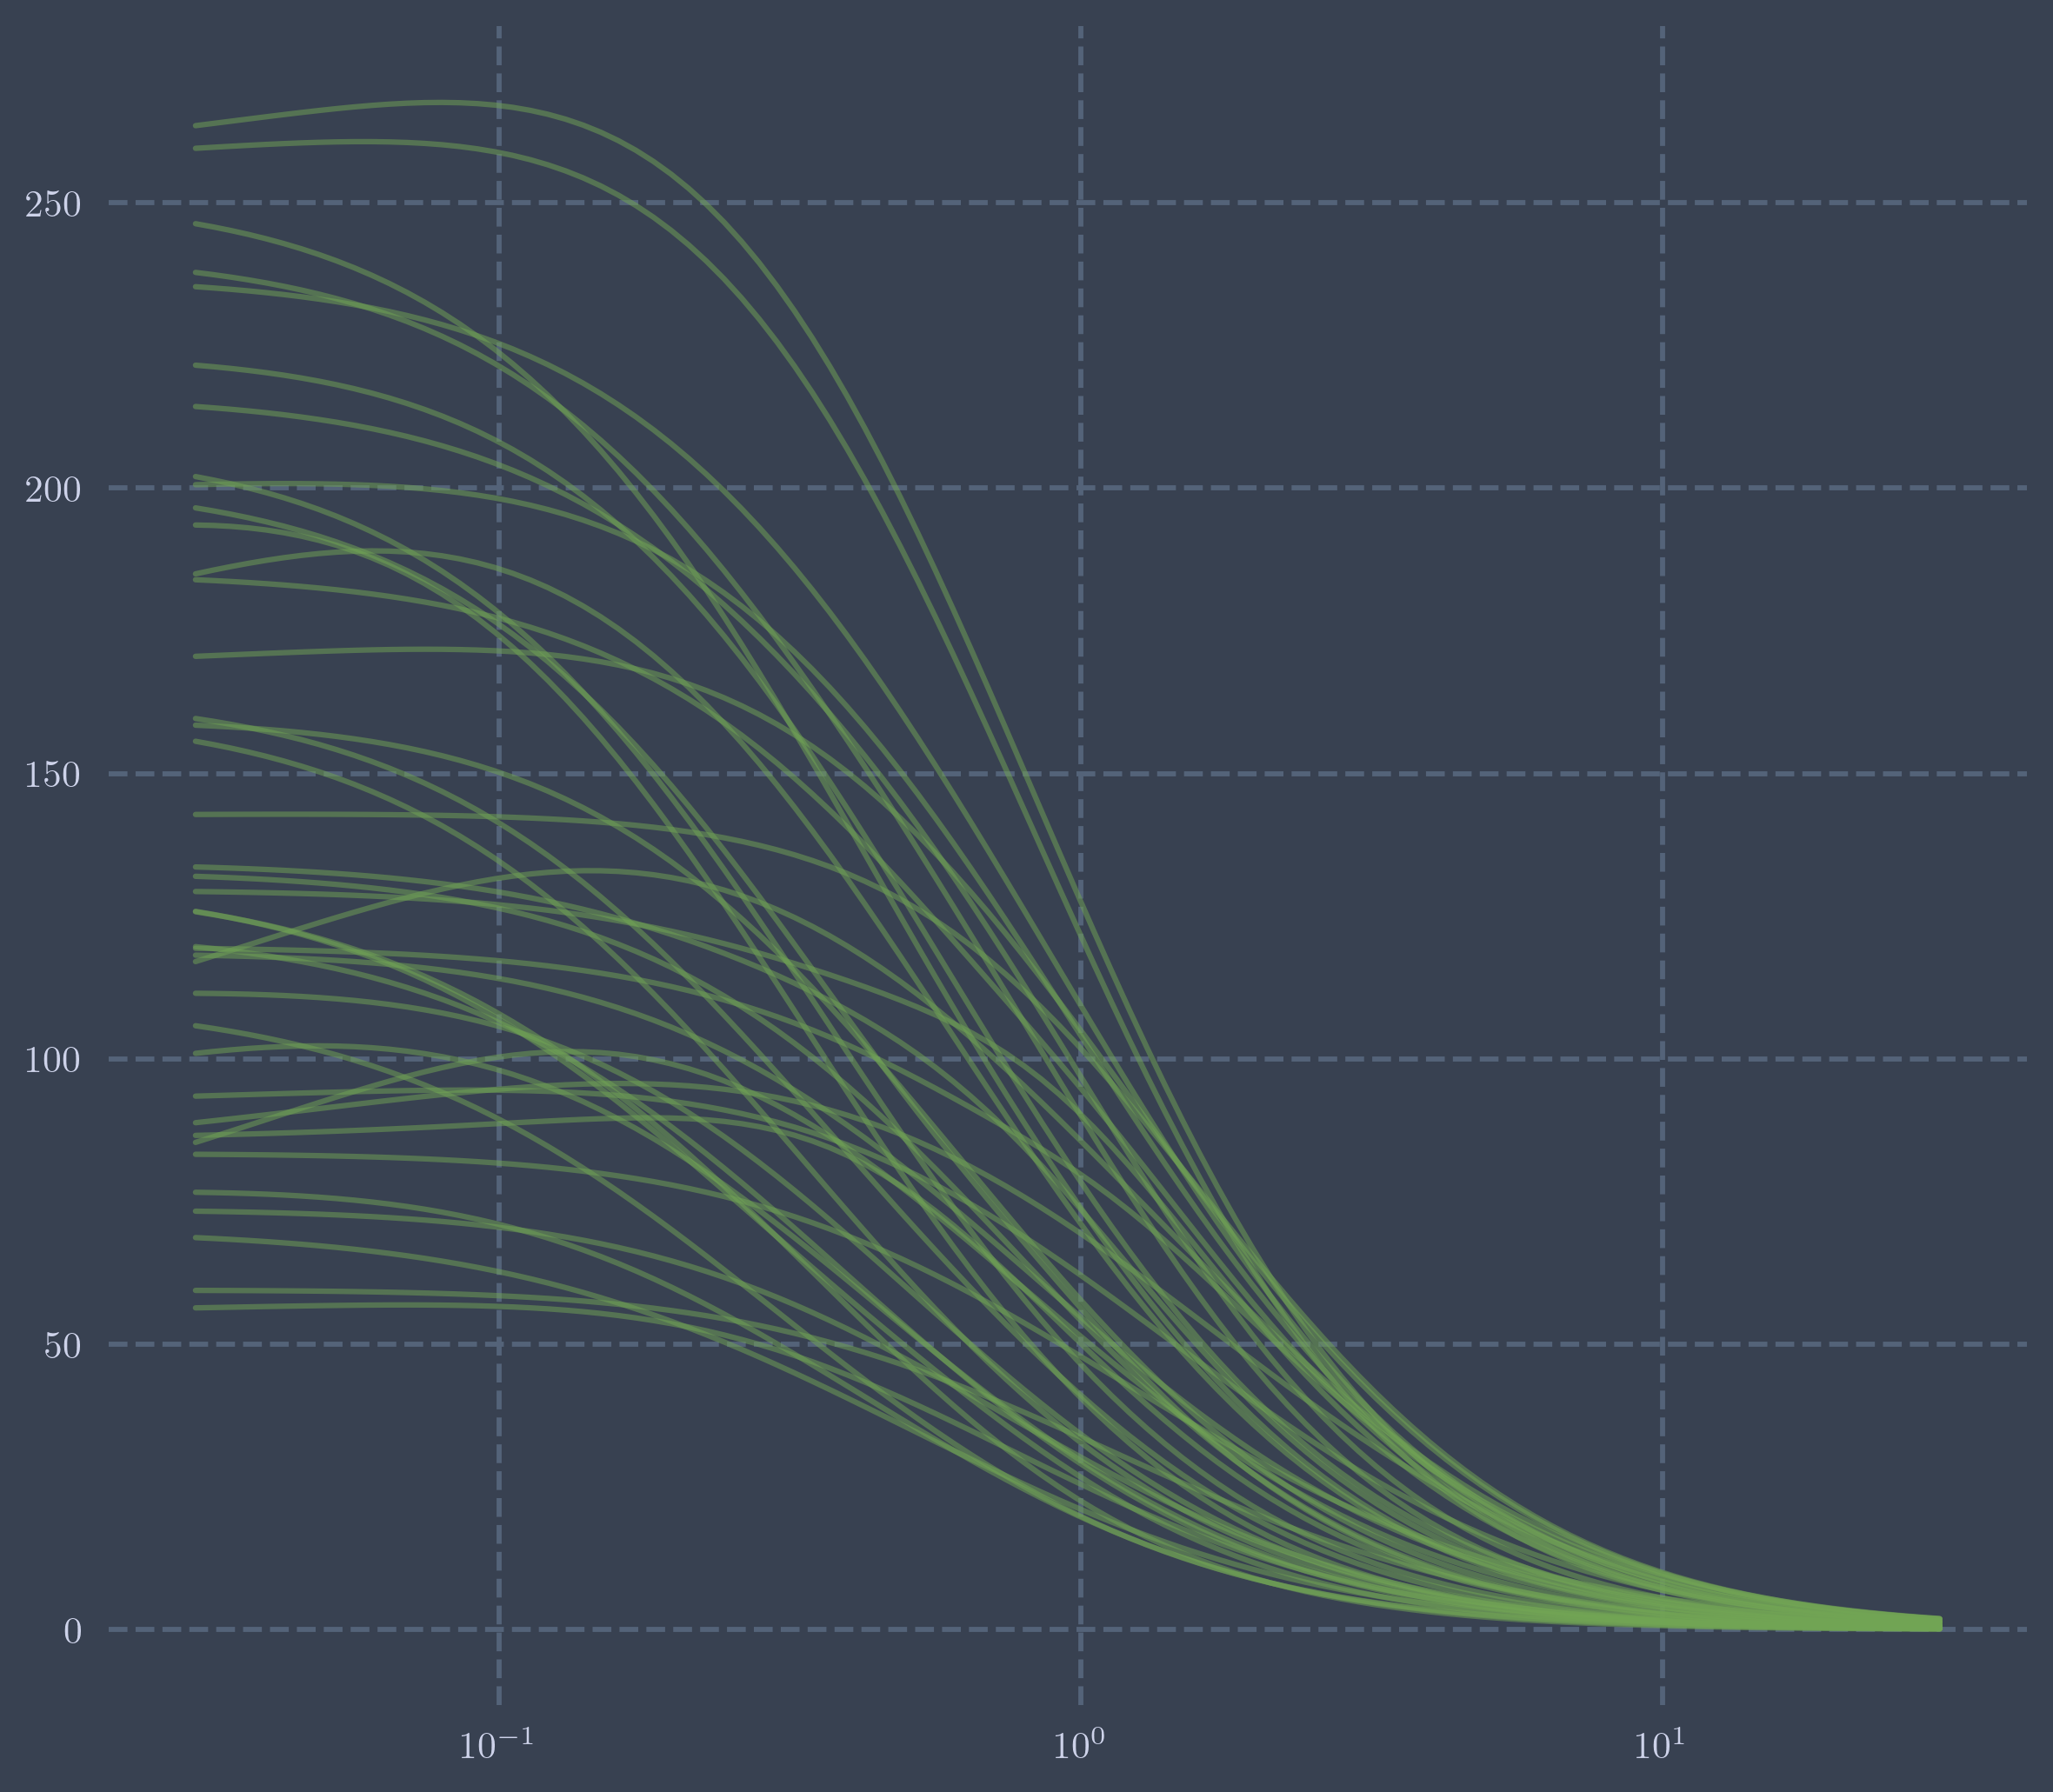

In [8]:
plt.plot(rs, esds, color=colors[0], alpha=0.5)
plt.xscale('log')
pass

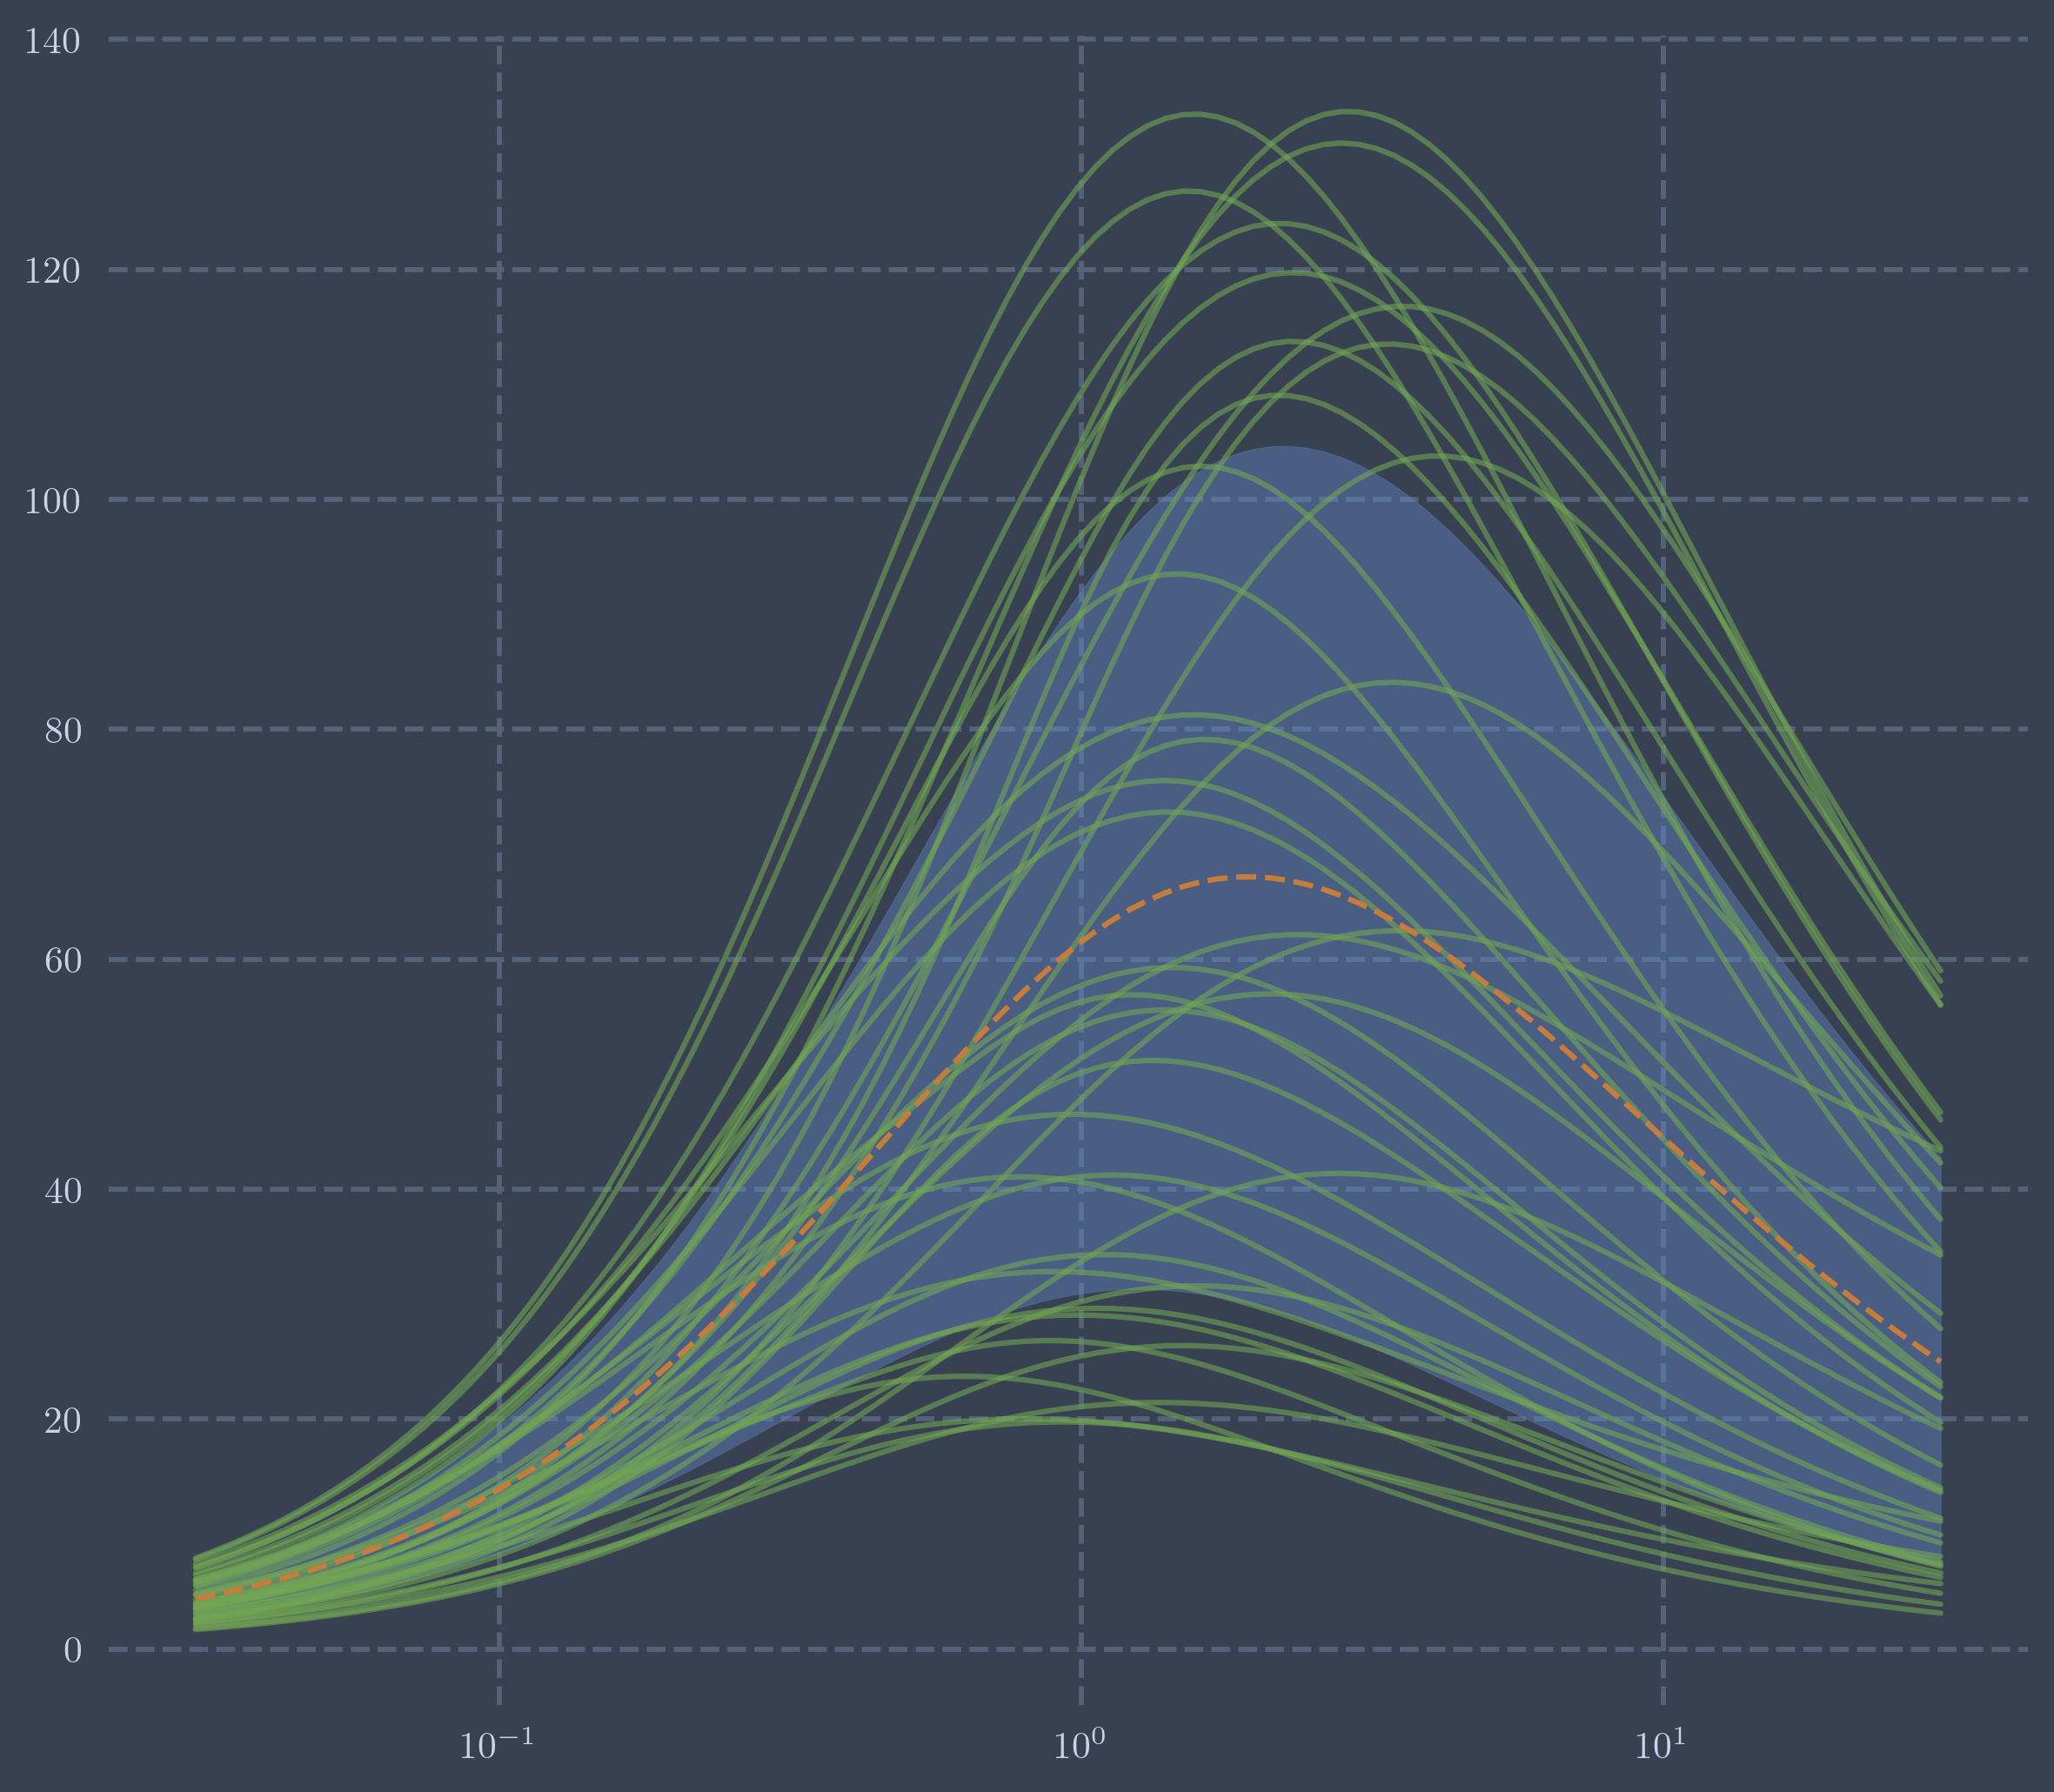

In [9]:
data = rs[:, None]*esds
plt.plot(rs, data, color=colors[0], alpha=0.6)
plt.plot(rs, data.mean(axis=-1), color=colors[2], alpha=1, linestyle='--')
plt.fill_between(rs,
                 data.mean(axis=-1) - data.std(axis=-1),
                 data.mean(axis=-1) + data.std(axis=-1), color=colors[3], alpha=0.4)
plt.xscale('log')
pass

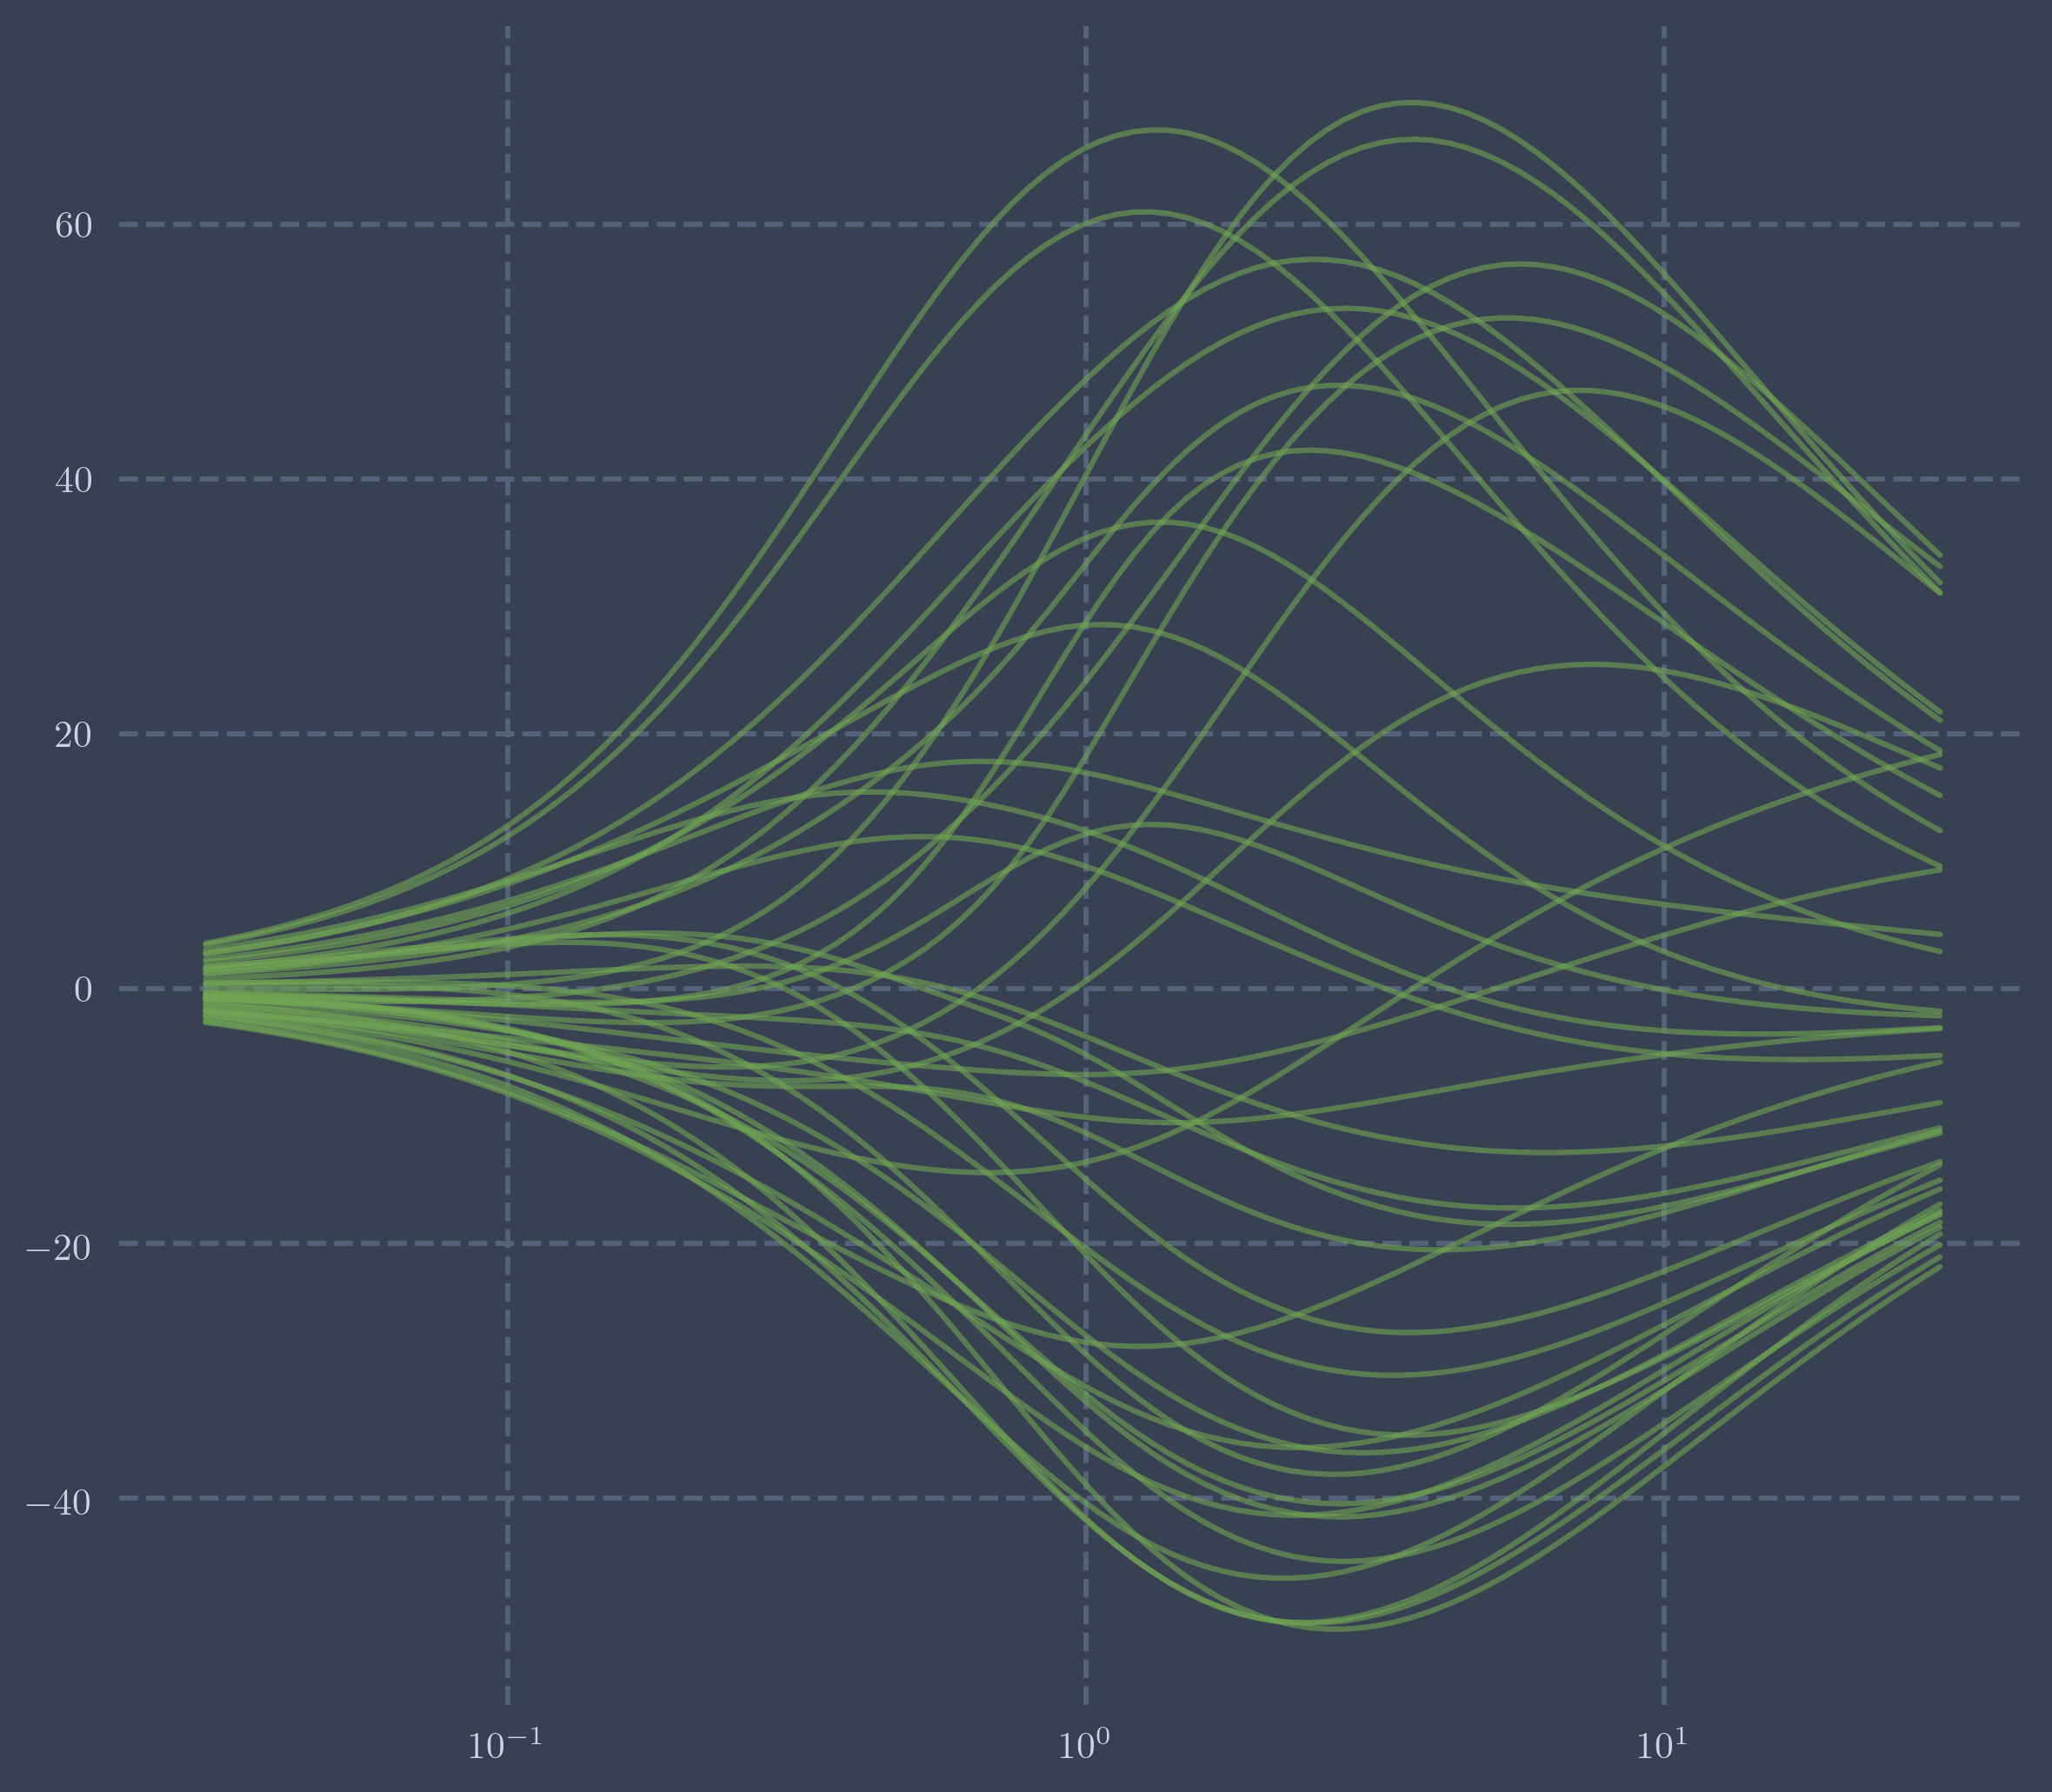

In [10]:
shifted = data - data.mean(axis=-1)[:, None]

plt.plot(rs, shifted, color=colors[0], alpha=0.6)
plt.xscale('log')
pass

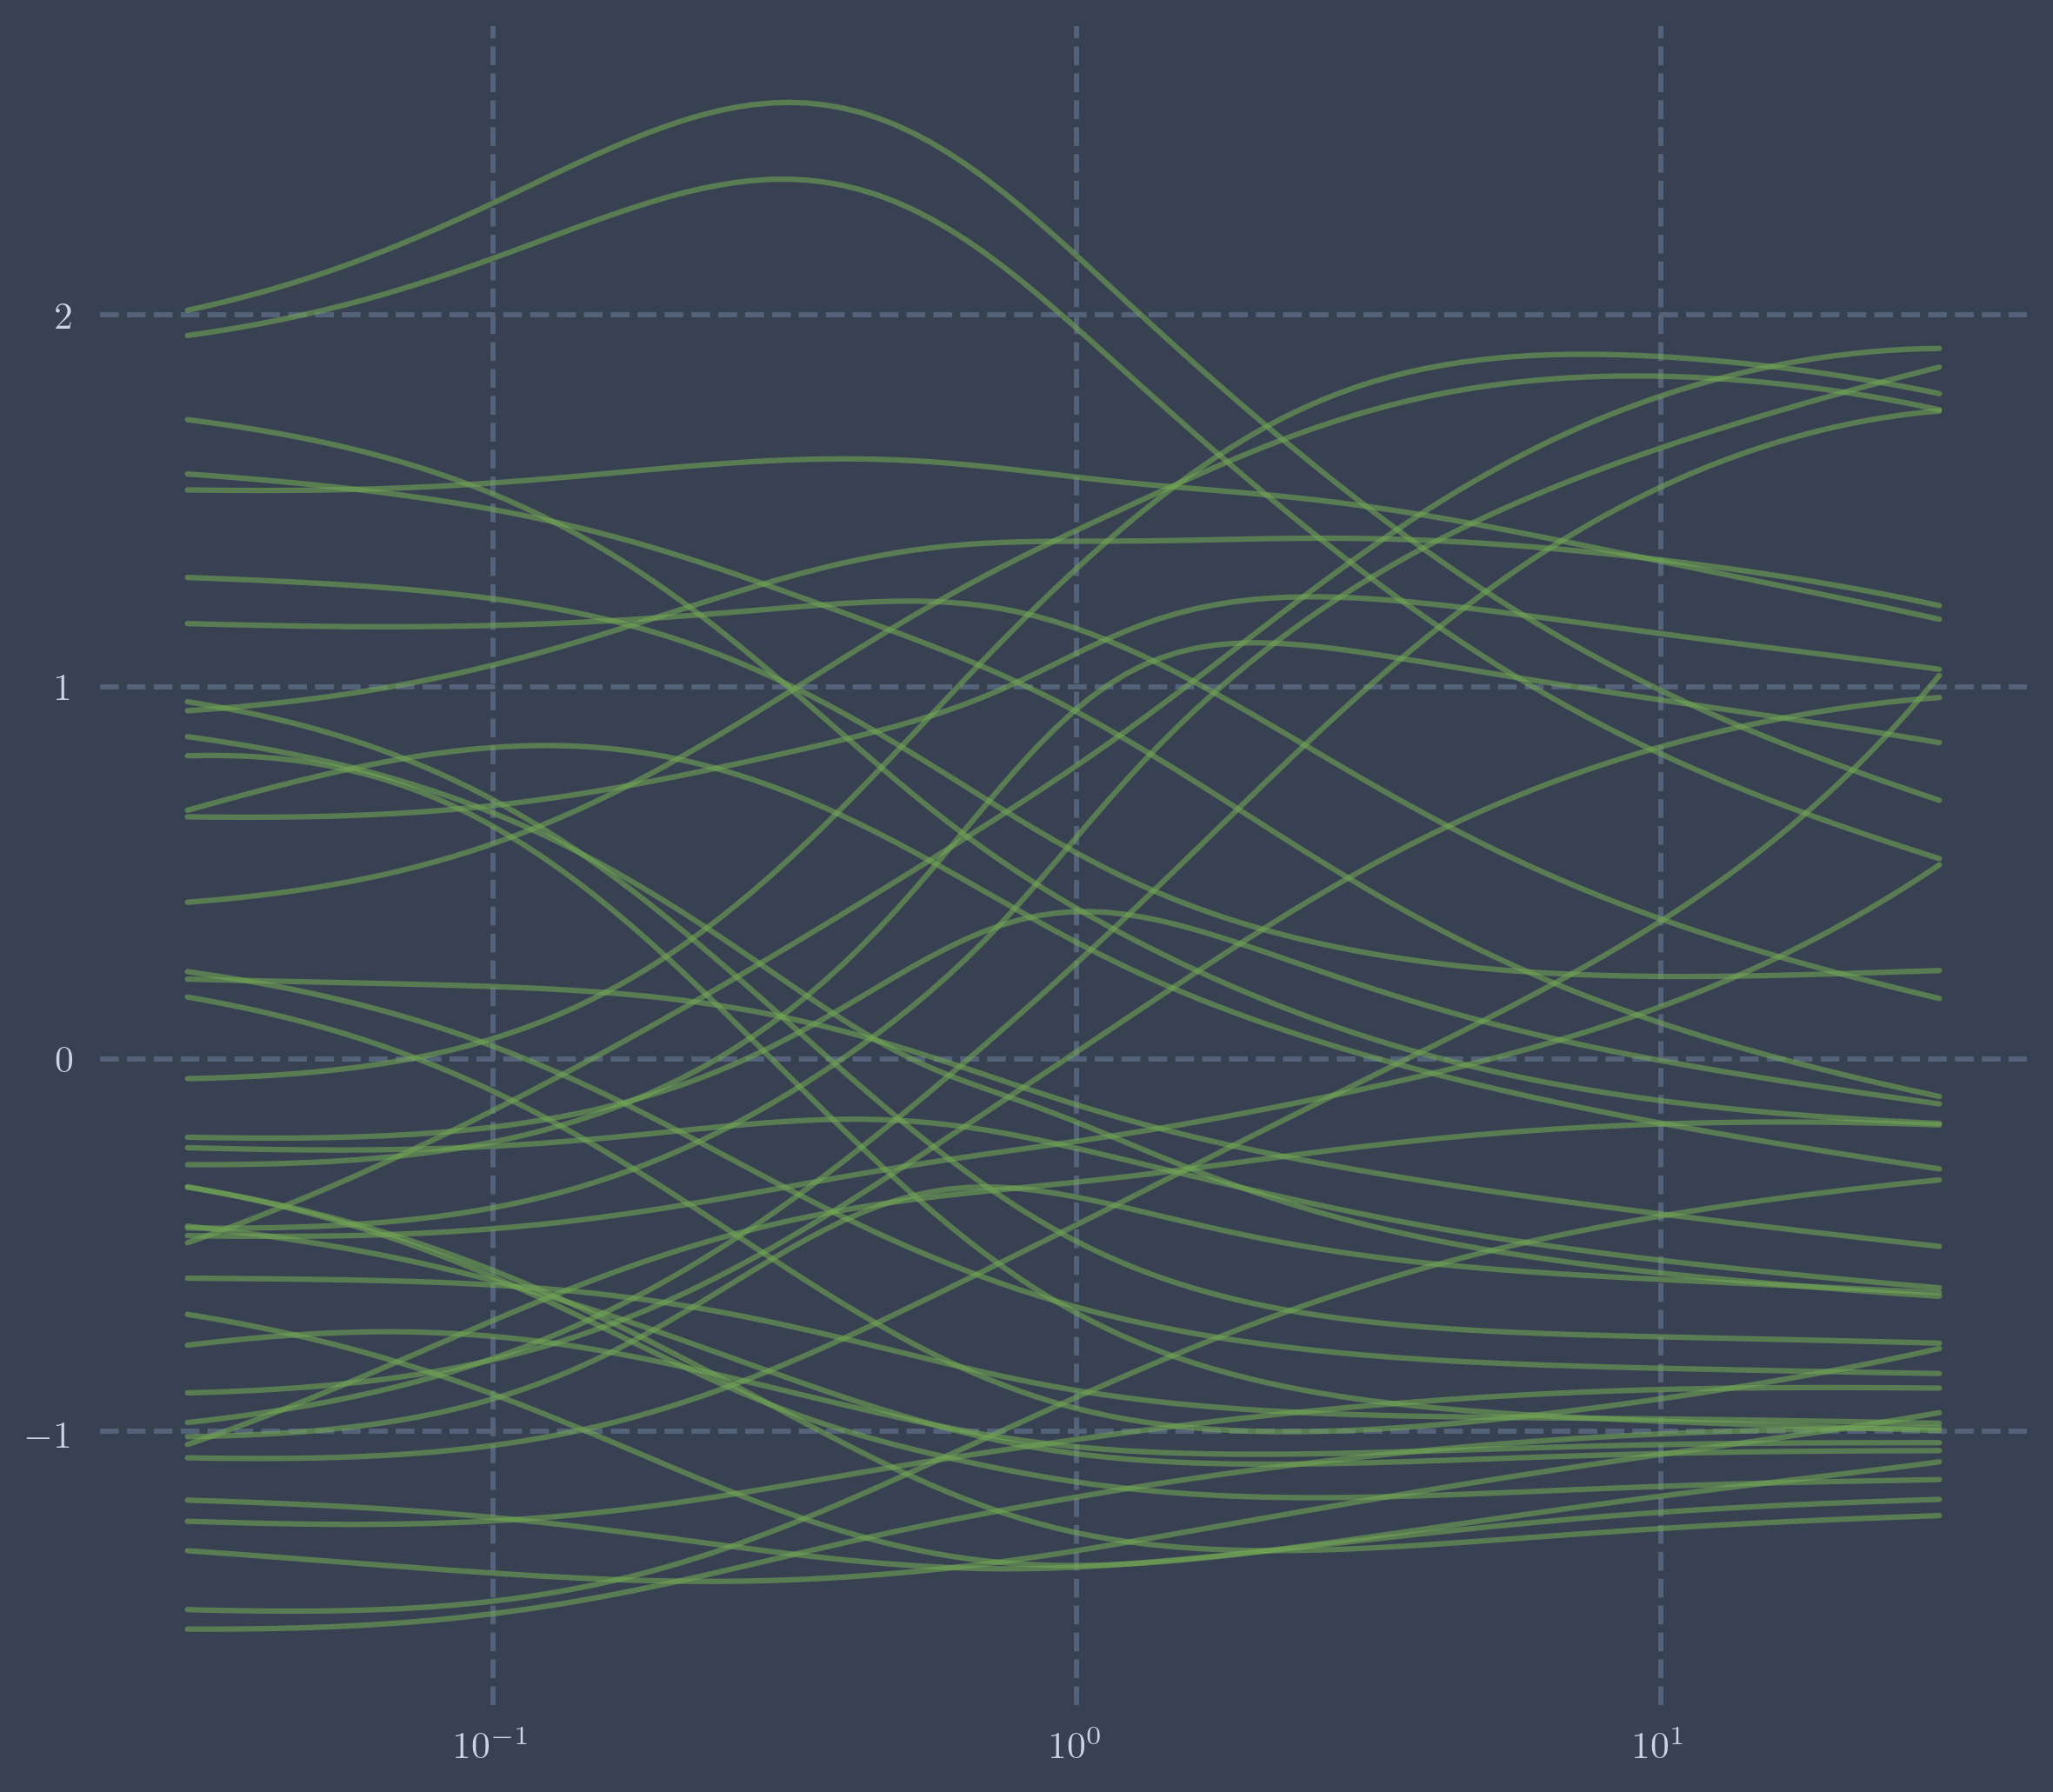

In [11]:
scaled_shifted = shifted/shifted.std(axis=-1)[:, None]

plt.plot(rs, scaled_shifted, color=colors[0], alpha=0.6)
plt.xscale('log')
pass

In [12]:
scaled_shifted.shape

(100, 40)

In [13]:
pca = pality.Pca.calculate(scaled_shifted)

In [14]:
phis = pca.basis_vectors
weights = pca.weights
explained_var = pca.explained_variance

In [15]:
for v in explained_var:
    if v > 1e-6:
        print(100*v)
    else:
        break

78.56321339360757
20.312490973399324
0.9544810085240494
0.13243727558510499
0.029835356774995173
0.0056413245148036785
0.001530417408735626
0.00029376485006402206


In [16]:
np.allclose((phis @ weights), scaled_shifted)

True

In [21]:
phis_ = phis[:, :8]
weights_ = weights[:8, :]
print(np.allclose(phis_ @ weights_, scaled_shifted, atol=1e-2))
print(np.mean((phis_ @ weights_) - scaled_shifted))
print(np.max((phis_ @ weights_) - scaled_shifted))

True
-2.0458244473497976e-17
0.005994633452841125


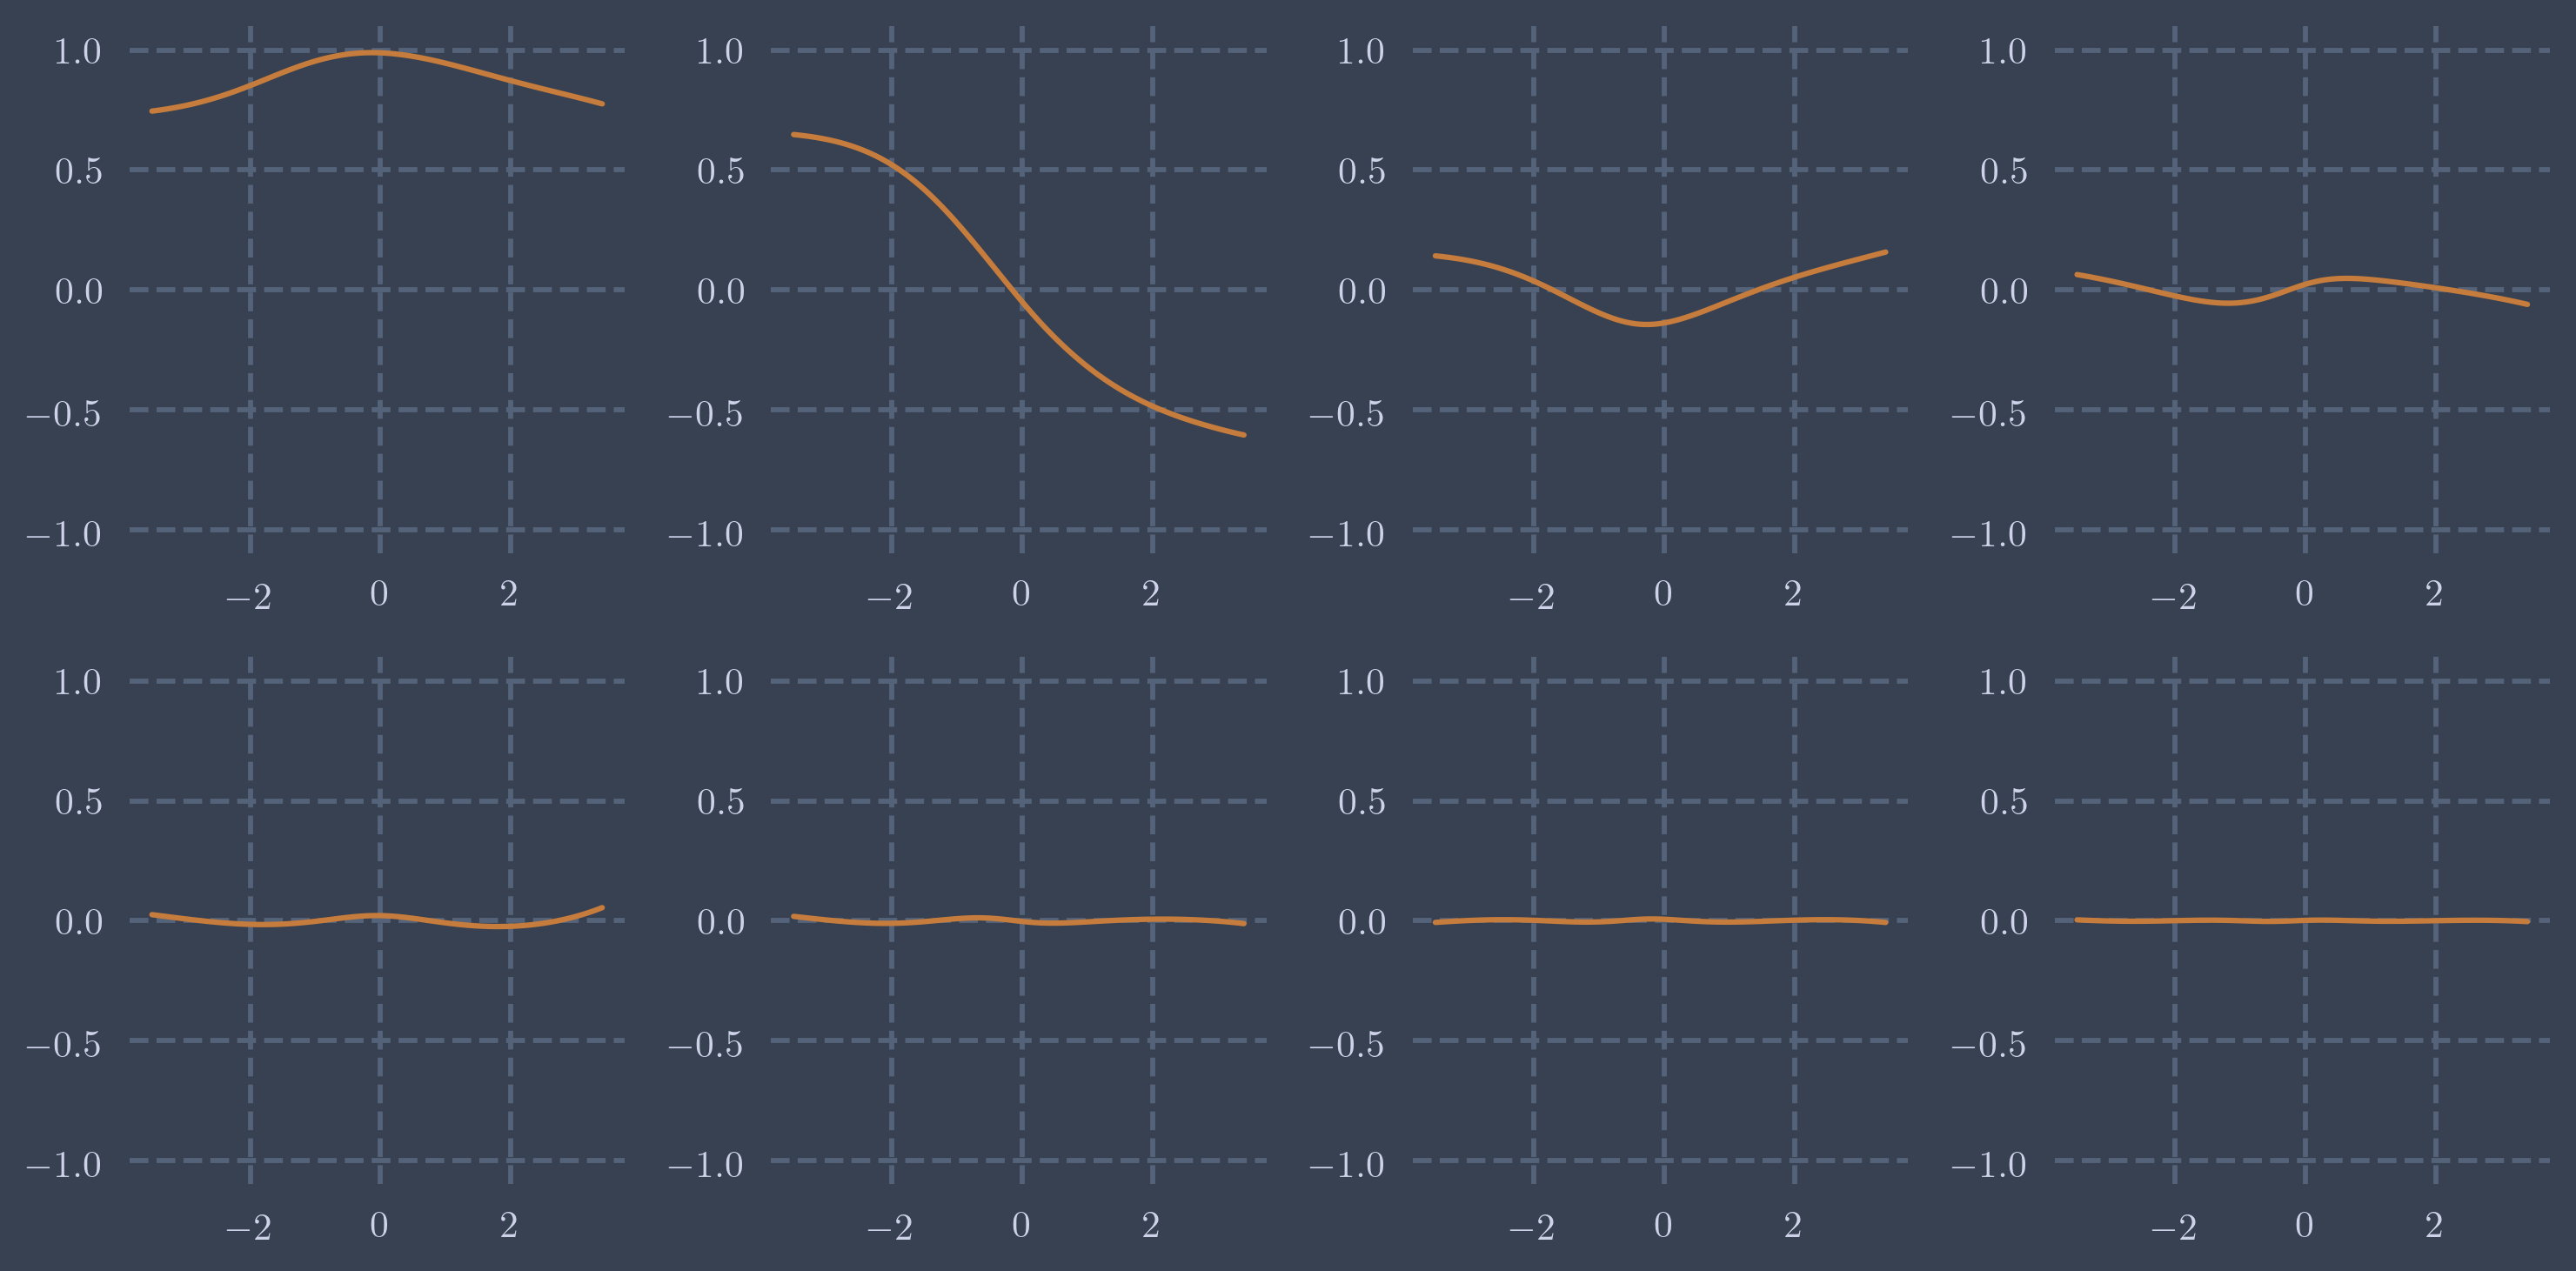

In [27]:
fig = plt.figure(figsize=(10, 5))

for i in range(8):
    plotnum = 241 + i
    ax = fig.add_subplot(plotnum)
    ax.plot(np.log(rs), phis_.T[i], color=colors[2])
    ax.set_ylim(-1.1, 1.1)